<a href="https://colab.research.google.com/github/Sakiba1705/CLIP-Vision-Transformer-Approach-Melanoma-Detection/blob/main/Melanoma_detection_using_pre_trained_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
torch.__version__

'2.0.1+cu118'

#Load the libraries

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

Check for device

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sakibaakter1911359","key":"4be5d3cb6a8cc5171ec15f15bc79430d"}'}

In [7]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [8]:
!kaggle datasets download -d drscarlat/melanoma

100% 5.24G/5.26G [00:58<00:00, 169MB/s]
100% 5.26G/5.26G [00:58<00:00, 96.8MB/s]


In [9]:
! unzip /content/melanoma.zip

Streaming output truncated to the last 5000 lines.
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031354.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031355.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031357.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031358.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031362.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031363.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031365.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031366.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031367.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031370.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031375.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031380.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031382.jpg  
  inflating: dermmel/DermMel/train_sep/

# Setup directory paths to train and test images

In [10]:
train_dir = '/content/DermMel/train_sep'
test_dir = '/content/DermMel/test'

#Plot data distribution

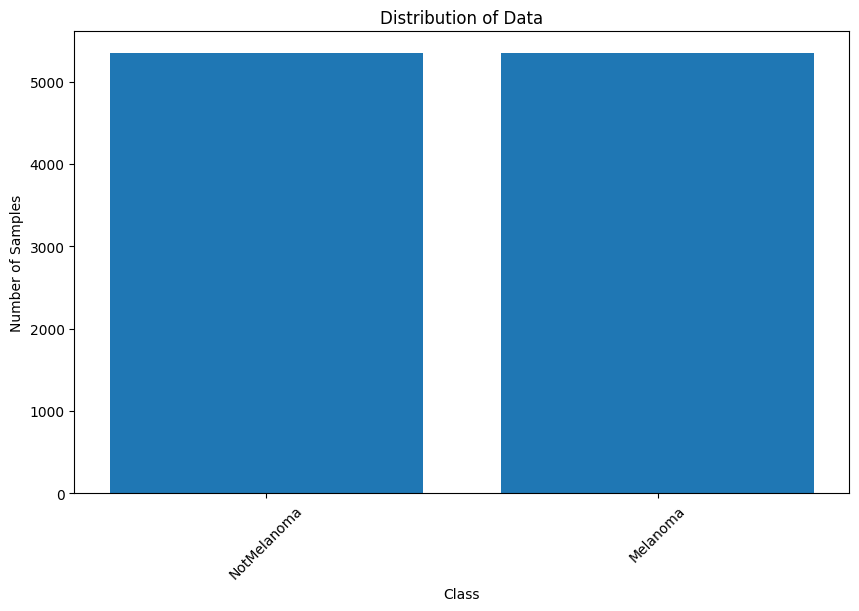

In [11]:
import os
import matplotlib.pyplot as plt

# Define the directory containing training data
train_dir = '/content/DermMel/train_sep'

# Get a list of class names
class_names = os.listdir(train_dir)

# Initialize a dictionary to store the count of samples in each class
class_counts = {}

# Loop through the class names and count the number of samples in each class
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    num_samples = len(os.listdir(class_path))
    class_counts[class_name] = num_samples

# Convert the class_counts dictionary into two separate lists: class_names and counts
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar chart to visualize the distribution of data
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Data')
plt.xticks(rotation=45)  # Rotate class labels for better visibility
plt.show()


#Let's visualize image

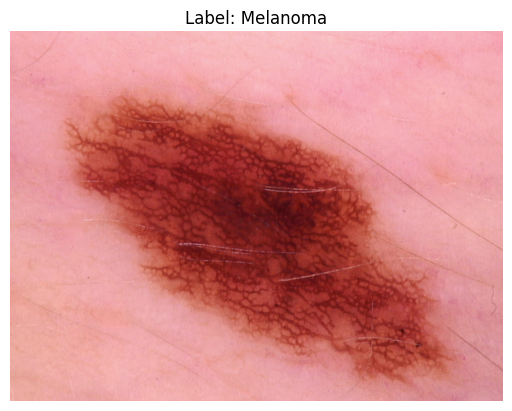

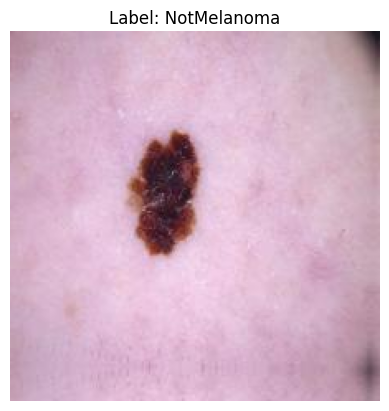

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_image(image_path, label, class_names):
    # Load the image
    img = mpimg.imread(image_path)

    # Display the image with the label
    plt.imshow(img)
    plt.title(f'Label: {class_names[label]}')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# Example usage for a custom image
custom_image_path = "/content/DermMel/train_sep/NotMelanoma/ISIC_0024308.jpg"
custom_label = 1  # Assuming 1 corresponds to 'NotMelanoma'
visualize_image(custom_image_path, custom_label, class_names)

# Example usage for another custom image
custom_image_path = "/content/DermMel/test/Melanoma/AUG_0_1001.jpeg"
custom_label = 0  # Assuming 0 corresponds to 'Melanoma'
visualize_image(custom_image_path, custom_label, class_names)


#Pre-trained ViT

In [13]:
#1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

#2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

#3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

#4. Change the classifier head
class_names = ['Melanoma','NotMelanoma']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 294MB/s]


In [14]:
!pip install torchinfo

# Print a summary using torchinfo

In [15]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

# Get automatic transforms from pretrained ViT weights

In [16]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


#Create Dataloaders

In [17]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

# Setup dataloaders

In [18]:

train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [19]:
!unzip going_modular

Archive:  going_modular.zip
   creating: going_modular/going_modular/
   creating: going_modular/going_modular/__pycache__/
  inflating: going_modular/going_modular/__pycache__/engine.cpython-39.pyc  
  inflating: going_modular/going_modular/__pycache__/predictions.cpython-39.pyc  
  inflating: going_modular/going_modular/engine.py  
  inflating: going_modular/going_modular/model_builder.py  
  inflating: going_modular/going_modular/predictions.py  
  inflating: going_modular/going_modular/train.py  
  inflating: going_modular/going_modular/utils.py  


#Train the model on dataset

In [20]:
import going_modular

In [21]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2141 | train_acc: 0.9182 | test_loss: 0.1802 | test_acc: 0.9297
Epoch: 2 | train_loss: 0.1653 | train_acc: 0.9367 | test_loss: 0.1828 | test_acc: 0.9225
Epoch: 3 | train_loss: 0.1559 | train_acc: 0.9399 | test_loss: 0.1668 | test_acc: 0.9372
Epoch: 4 | train_loss: 0.1494 | train_acc: 0.9416 | test_loss: 0.1625 | test_acc: 0.9369
Epoch: 5 | train_loss: 0.1438 | train_acc: 0.9437 | test_loss: 0.1589 | test_acc: 0.9368
Epoch: 6 | train_loss: 0.1384 | train_acc: 0.9425 | test_loss: 0.1587 | test_acc: 0.9392
Epoch: 7 | train_loss: 0.1352 | train_acc: 0.9471 | test_loss: 0.1549 | test_acc: 0.9365
Epoch: 8 | train_loss: 0.1313 | train_acc: 0.9472 | test_loss: 0.1579 | test_acc: 0.9386
Epoch: 9 | train_loss: 0.1289 | train_acc: 0.9477 | test_loss: 0.1572 | test_acc: 0.9390
Epoch: 10 | train_loss: 0.1273 | train_acc: 0.9475 | test_loss: 0.1552 | test_acc: 0.9408


#Classification report and Confusion Matrix

Accuracy: 94.05%
Classification Report:
              precision    recall  f1-score   support

    Melanoma       0.97      0.90      0.94      1781
 NotMelanoma       0.91      0.98      0.94      1780

    accuracy                           0.94      3561
   macro avg       0.94      0.94      0.94      3561
weighted avg       0.94      0.94      0.94      3561



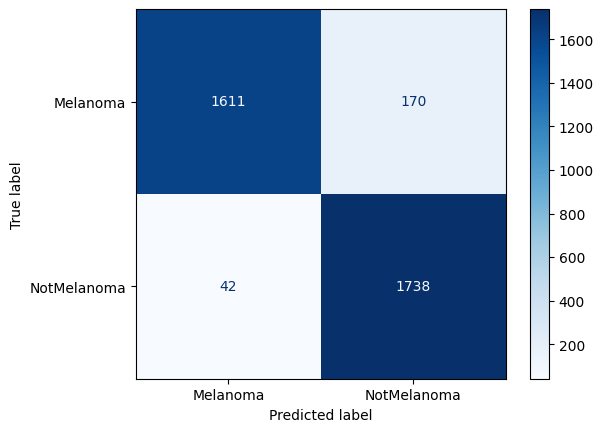

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate the model on the test dataset
def evaluate_model(model, test_dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions)

# Evaluate the model
true_labels, predicted_labels = evaluate_model(pretrained_vit, test_dataloader_pretrained)

# Compute confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Compute precision, recall, and F1-score
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format="d")

# Calculate accuracy
accuracy = np.trace(confusion) / np.sum(confusion)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print precision, recall, and F1-score
print("Classification Report:")
print(report)


# Plot the loss and accuracy curves

In [23]:
import helper_functions

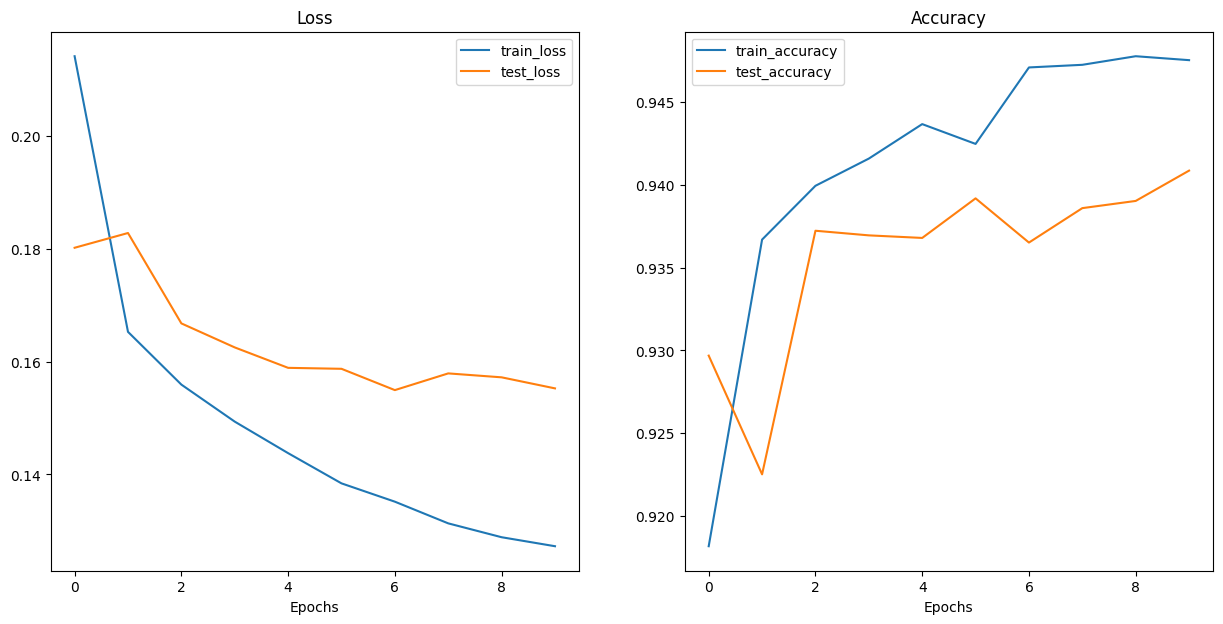

In [24]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

# Make Prediction:

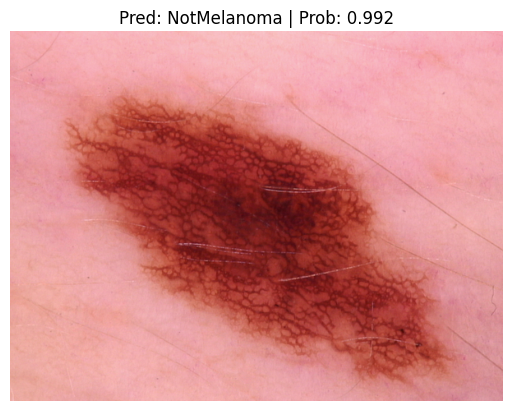

In [25]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "/content/DermMel/train_sep/NotMelanoma/ISIC_0024308.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

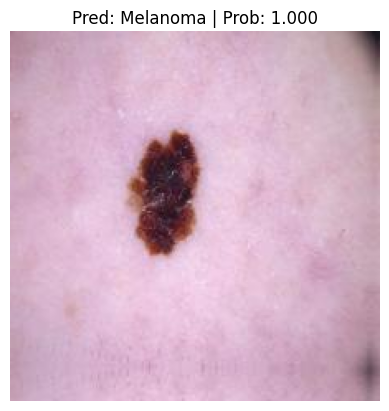

In [26]:
from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "/content/DermMel/test/Melanoma/AUG_0_1001.jpeg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)